<a href="https://colab.research.google.com/github/miguel-mb-cell/Transfer-Learning-DIO/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

##Objetivo
Esse estudo tem o objetivo de aprender como usar uma rede neural **já treinada** e otimizada para aproveitar sua estrutura para adapta-la a **novas** tarefas.

Caso queira executar e editar as células, clique em "Arquivo" na barra de ferramentas e em "Salvar uma cópia no Drive" para replicar o notebook no seu próprio Drive.

##Procedimento
Será usada a rede neural **VGG16**, que é um classificador de imagens de 1000 classes, que ganhou o desafio do ImageNet em 2014. Essa competição anual avalia algoritmos de detecção de objetos e classificação de imagens em uma grande escala e tem sido fundamental para o avanço da visão computacional e *deep learning*.

Será feito o carregamento e pré-processamendo do dataset de gatos e cachorros, disponível em: [Kaggle Cats and Dogs Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Será feita uma cópia da rede neural **VGG16** e sua última camada será substituída para ser treinada com o dataset mencionado acima.

## O que é Transfer Learning
Transfer Learning é uma técnica de aprendizado de máquina onde um modelo treinado para uma tarefa é reutilizado como ponto de partida para outra tarefa relacionada. Em vez de treinar um modelo do zero para cada novo problema, o Transfer Learning permite aproveitar o conhecimento já adquirido por um modelo pré-treinado. Isso pode resultar em uma economia significativa de tempo e recursos, além de proporcionar melhor desempenho, especialmente quando se dispõe de um conjunto de dados limitado como é no caso desse estudo.

### Benefícios:

* Economia de Tempo: Menos tempo de treinamento comparado a treinar um modelo do zero.

* Desempenho Melhorado: Modelos pré-treinados já capturaram características úteis de muitas imagens, o que pode melhorar a precisão em tarefas novas.

* Eficiência de Dados: Funciona bem mesmo com conjuntos de dados menores.

##Importações necessárias para este estudo.

In [ ]:
import os

# If you're using TensorFlow with GPU
# os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.applications import VGG16


## Preparando o dataset

Aqui, vamos encontrar o dataset localizado no Drive. A estrutura das pastas já separa as categorias do dataset:

>PetImages/ (raiz)
>>Cat/ (categoria)
>>>0.jpg<br>
>>>1.jpg<br>
>>>...
>>
>>Dog/ (categoria)
>>>0.jpg<br>
>>>1.jpg<br>
>>>...

Importante destacar que eu não carreguei a pasta inteira, apenas as primeiras 250 imagens, para econimzar tempo.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

root = "/content/drive/MyDrive/PetImages"

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print("Categorias encontradas:", categories)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Categorias encontradas: ['/content/drive/MyDrive/PetImages/Cat', '/content/drive/MyDrive/PetImages/Dog']


A função abaixo é usada para pré-processar os dados em uma imagem e vetor de input.

Vamos entender os passos:

* a imagem é redimensionada para o tamanho 224 por 224 pixels;
* a imagem é transformada em um array;
* o array é redimensionado para criar um batch com essa imagem (batch é o formato esperado pelo modelo durante o treinamento);
* o array é pré-processado para que esteja no formato esperado pelo modelo;
* a função retorna a imagem original (img) e a imagem pré-processada (x) que pode ser usada pelo modelo.

In [ ]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Aplica a função a todas as imagens do dataset para padroniza-lo e armazena os dados em uma lista

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

Embaralhar os dados

In [ ]:
random.shuffle(data)

Separar os dados para treinamento (70%), validação (15%) e teste (15%)

In [ ]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separar os dados para labels

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]


Converte os dados para o tipo float32 e normaliza os valores dos pixels para que fiquem entre 0 e 1. Essa etapa é importante para que o treino seja mais eficiente e estável, evitando grandes diferenças de escala.

Converter as labelas para vetores do tipo one-hot (vetores binários que representam as categorias) também é fundamental para que o modelo diferencie as classes de maneira correta.

In [ ]:
# normalizar os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# converter as labels para vetores do tipo one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_test.shape)

(76, 2)


Resumo do que temos até agora

In [ ]:
print(f"Foram carregadas {len(data)} imagens de {num_classes} categorias")
print(f"Treino: {len(x_train)} / Validação: {len(x_val)} / Teste: {len(x_test)}")
print("Formato dos dados de treino: ", x_train.shape)
print("Formato das labels de treino: ", y_train.shape)

Foram carregadas 502 imagens de 2 categorias
Treino: 351 / Validação: 75 / Teste: 76
Formato dos dados de treino:  (351, 224, 224, 3)
Formato das labels de treino:  (351, 2)


Alguns exemplos das imagens do dataset

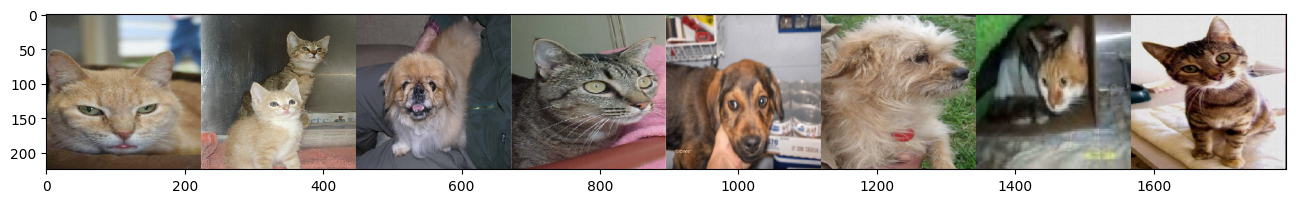

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## O modelo VGG16

Vamos instanciar o modelo VGG16 do keras, que foi treinado pelo ImageNet e tem os pesos salvos na internet.

O VGG16 foi criado para resolver o ImageNet que é um grande banco de dados de imagens usado para pesquisas. O modelo alcança 8.8% top-5 taxa de erros, o que significa que 91.2% das amostras foram classificadas corretamente dentro das primeiras 5 previsões da imagem. A acurácia para a primeira previsão é 73%. Isso é mais impresionante ainda considerando que a rede usa 1000 classes, de forma que chutes aleatórios iriam resultar em apenas 0.1% de acurácia, o que indica que o treinamento da rede foi muito bem sucedido.

A primeira vez que o modelo for carregado pode demorar um pouco para baixar todos os pesos da web.

Com o método summary() é possível ver um resumo das características do modelo.

In [ ]:
vgg = VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Aqui, podemos ver que o modelo tem 13 camadas convolucionais e 3 camadas densas, totalizando 16 camadas treináveis, daí o nome VGG16.
Porém, contando também as camadas auxiliares são **23 camadas no total**, e um total de mais de **138 milhões de parâmetros!**

## Como funcionam as camadas
* **Input Layer:** define a forma de entrada que o modelo espera.
* **Conv2D (Camada Convolucional):** aplica filtros de convolução às imagens de entrada, extraindo características como bordas, texturas e padrões.
* **MaxPooling2D:** Reduz a dimensionalidade de entrada, selecionando o valor máximo em cada região (pooling) da imagem.
* **Flatten:** achata a saída tridimensional das camadas de convolução e pooling em um vetor unidimensional, preparando os dados para as camadas densamente conectadas.
* **Dense (Fully Connected Layer):** aplica transformações lineares e não-lineares aos dados. Cada neurônio está conectado a todos os outros da camada anterior. Realiza a classificação final ou outras previsões com base nas características extraídas da imagem.

## Reaproveitando o modelo VGG16
Para usar essa rede para outra tarefa, é necessário remover a última camada e substituir por uma nova camada para poder treina-la com o dataset carregado anteriormente.

Para isso, criei uma cópia do VGG16 da camada de input até a penúltima camada. Essa cópia não é uma duplicata, é na verdade apenas uma referencia às camadas já existentes, então não se preocupe com o uso de memória.

In [ ]:
# faz a cópia da camada de input do modelo usado no código acima
camada_input = vgg.input

# declara uma nova camada softmax com a mesma quantidade de neurônios que o número de classes
nova_camada = Dense(num_classes, activation='softmax')

# conecta a nova camada às layers do modelo
camada_output = nova_camada(vgg.layers[-2].output)

# cria uma nova rede com essas camadas
novo_modelo = Model(camada_input, camada_output)

Vamos retreinar essa nova rede para o nosso dataset, mas primeiro, é necessário salvar os pesos e viéses (*biases*) que já existem nas camadas da rede exceto na última camada.

Ao configurar o atributo "*trainable*" como falso, exceto na útlima camada, todos os pesos e viéses nas camadas que não serão treinadas permanecerão os mesmos.

Ao final, chama o summary() novamente para ver como o modelo está.

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(novo_modelo.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(novo_modelo.layers[-1:]):
    layer.trainable = True

novo_modelo.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

novo_modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Se você usar o mesmo dataset que eu, verá que os parâmetros treináveis agora são apenas 8 mil, sendo que no modelo normal, são mais de 138 milhões. Isso porque apenas os parâmetros da última camada são treináveis, todas as outras camadas manterão os mesmos valores.

##Conclusão
Agora, vamos de fato treinar esse novo modelo com o nosso dataset

In [ ]:
history = novo_modelo.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 300s 109s/step - accuracy: 0.5505 - loss: 1.1679 - val_accuracy: 0.5067 - val_loss: 0.8510
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 323s 110s/step - accuracy: 0.4775 - loss: 0.8609 - val_accuracy: 0.4933 - val_loss: 0.8893
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 299s 95s/step - accuracy: 0.5035 - loss: 0.7981 - val_accuracy: 0.5067 - val_loss: 0.7553
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 308s 92s/step - accuracy: 0.5279 - loss: 0.7170 - val_accuracy: 0.6800 - val_loss: 0.5827
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 299s 107s/step - accuracy: 0.6403 - loss: 0.6003 - val_accuracy: 0.5467 - val_loss: 0.5882
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 276s 88s/step - accuracy: 0.7054 - loss: 0.5479 - val_accuracy: 0.7200 - val_loss: 0.5319
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 330s 118s/step - accuracy: 0.7256 - loss: 0.5184 - val_accuracy: 0.8800 - val_loss: 0.4713
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 265s 94s/step - accuracy: 0.8633 - loss: 0.4603 - val_accuracy: 0.8267 - val_l

Podemos ver que a acurácia fica em torno de 85%  no final o que é impressionante considerando que o dataset de treinamento que usei é pequeno, com apenas 500 imagens.

Isso mostra como a técnica de **transfer learning** é eficiente para econimizar tempo de desenvolvimento e treinamento, alcançando um alto nível de acurácia mesmo com um dataset limitado.

## Teste o modelo você mesmo!

Para brincar um pouco com o novo modelo criado, vamos passar imagens da internet para ele classificar como gato ou cachorro.

Primeiro, execute a célula abaixo para declarar as funções ncessárias

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar imagem do {url}: {e}")
        print("Tente com outra url!")
        return None
    except PIL.UnidentifiedImageError as e:
        print(f"Error abrindo imagem do {url}: {e}")
        print("Tente com outra url!")
        return None


def show_image(url):
    img = download_image(url)
    if img:
        plt.imshow(img)
        plt.axis('off')
        plt.show()


def classify_image(url, model):
    img = download_image(url)
    if img:
        img_resized = img.resize((224, 224))
        x = image.img_to_array(img_resized)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        prediction = model.predict(x)

        class_idx = np.argmax(prediction[0])
        class_label = 'Gato' if class_idx == 0 else 'Cachorro'

        print(f'Classificação: {class_label}')
        print(f'Pontuações: {prediction[0]}')

Agora, pegue o link de uma imagem na internet, de um gato ou cachorro, e passe para a variável "url" abaixo.

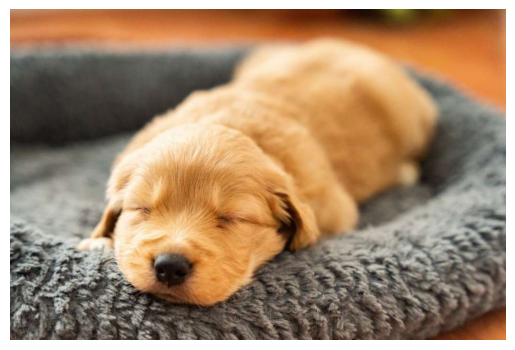

In [ ]:
url = 'https://p2.trrsf.com/image/fget/cf/940/0/images.terra.com/2024/01/16/349788060-filhote-de-cachorro-dormindo.jpg'
show_image(url)

Veja a classificação!

In [ ]:
classify_image(url, novo_modelo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
Classificação: Cachorro
Pontuações: [2.1578786e-10 1.0000000e+00]


## Referências

* VARSHNEY, Paras. [VGGNet-16 Architecture: A Complete Guide
](https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide). Kaggle, 22 jul. 2020.

* MUREL, Jacob; KAVLAKOGLU, Eda. [What is transfer learning?](https://www.ibm.com/topics/transfer-learning) IBM, 12 fev. 2024.

* Notebook de referência sugerido no bootcamp da DIO: [Transfer learning / fine-tuning](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb)